In [1]:
%matplotlib inline

# 基础理论

k-近邻算法（k-Nearest Neighbor classifier，KNN）是一种非参数化模型。KNN算法本身是非常简单的，可以归纳为以下几步：

- 选择近邻的数量k和距离度量方法；
- 找到待分类样本的k个最近邻居；
- 根据最近邻的类标进行**多数投票**。

这种基于记忆的学习算法的**优点**在于：分类器可以快速地适应新的训练数据。不过其**缺点**也是显而易见的：在最坏情况下，计算复杂度随着样本数量的增多而呈线性增长，除非数据集中的样本维度（特征数量）有限，而且使用了高效的数据结构（如KD树等）。此外，我们还不能忽视训练样本，因为此模型没有训练的步骤。由此一来，如果使用了大型数据集，对于存储空间来说也是一个挑战。

# 距离度量标准

对KNN算法而言，找到正确的k值是在过拟合与欠拟合之间找到平衡的关键所在。我们还必须保证所选的距离度量标准适用于数据集中的特征。相对简单的欧几里得距离度量标准常用于特征值为实数的样本，如Iris数据集中的花朵，其特征值是以厘米为单位的实数。注意，当我们使用欧几里得距离时，对数据进行标准化处理，保持各属性度量的尺度统一也是非常重要的。

**闵可夫斯基距离**是对欧几里得距离及曼哈顿距离的一种泛化，可写作：

$$d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \sqrt[p]{\sum_{k}{|x_k^{(i)} \cdot x_k^{(j)}|^p}}$$

如果将参数设定为$p＝2$，则为**欧几里得距离**；当$p＝1$时，就是**曼哈顿距离**。`scikit-learn`中还实现了许多其他的距离度量标准，具体内容可见如下网址：http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html。

# 维度灾难

由于**维度灾难（Curse of Dimensionality）**的原因，使得KNN算法易于过拟合。维度灾难是指这样一种现象：对于一个样本数量大小稳定的训练数据集，随着其特征数量的增加，样本中有具体值的特征数量变得极其稀疏（大多数特征的取值为空）。直观地说，可以认为即使是最近的邻居，它们在高维空间中的实际距离也是非常远的，因此难以给出一个合适的类标判定。

正则化方法并不适用于决策树和KNN等算法，但可以使用**特征选择**和**降维**等技术来帮助其避免维度灾难。

# Coding

使用`scikit-learn`分别训练一个KNN模型, 并将其运用于Iris数据集中。

In [9]:
# 导入需要的库

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## 辅助函数

借助以下`plot_decision_region()`函数，可以绘制模型的决策区域，并观察不同样本的分类效果；其中，使用灰色小圆圈显示来自测试数据集的样本。

In [4]:
# %load scripts/plot_decision_region.py
# @Time    : 2018/5/10 22:45
# @Author  : SHeynckes
# @Email   : sheynckes@outlook.com
# @File    : plot_decision_region.py
# @Software: PyCharm


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min = X[:, 0].min() - 1
    x1_max = X[:, 0].max() + 1
    x2_min = X[:, 1].min() - 1
    x2_max = X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                    c=cmap(idx), marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c="grey", alpha=1.0,
                    linewidth=1, marker="o", s=55, label="Test Set")

## 数据准备

首先，通过`scikit-learn`中的`datasets`直接导入Iris数据集。提取150个花朵样本中的花瓣长度（petal length）和花瓣宽度（petal width）两个特征的值，并由此构建特征矩阵X，同时将对应花朵所属类型的类标赋值给向量y。

同时，为了评估训练得到的模型在未知数据上的表现，需要将数据集划分为训练数据集(含有105个数据）和测试数据集（含有45个数据）。

In [5]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

使用`scikit-learn`的`preprocessing`模块中的`StandardScaler`类对特征进行标准化处理。使用`StandardScaler`中的`fit()`方法，可以计算训练数据中每个特征的$\mu$（样本均值）和$\sigma$（标准差）。通过调用`transform()`方法，可以使用前面计算得到的$\mu$和$\sigma$来对训练数据做标准化处理。需注意的是，我们要使用相同的缩放参数分别处理训练和测试数据集，以保证它们的值是彼此相当的。

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 构建KNN模型

下面，以欧几里得距离为度量标准，使用`scikit-learn`实现了一个KNN模型。

In [10]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric="minkowski")
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print("Misclassified samples: %d" % (y_test != y_pred).sum())

Misclassified samples: 0


利用`plot_decision_regions()`函数绘制模型的决策区域，并观察不同样本的分类效果。将此数据集上的KNN模型的近邻数量设定为5个，我们得到了相对平滑的决策边界。

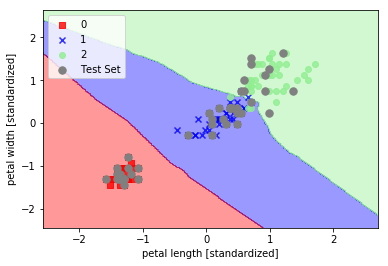

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()